In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer

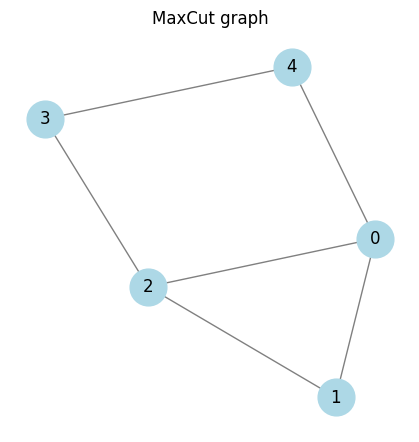

Initial params: [0.48834988 0.19009787]
Optimizer msg: Return from COBYLA because the trust region radius reaches its lower bound.
Optimal gammas: [2.81730587] betas: [0.35343829]

Top measured bitstrings & probabilities (Statevector):
01001  prob=0.1037  assignment=[1, 0, 0, 1, 0]  cut=5
10110  prob=0.1037  assignment=[0, 1, 1, 0, 1]  cut=5
01011  prob=0.1037  assignment=[1, 1, 0, 1, 0]  cut=5
10100  prob=0.1037  assignment=[0, 0, 1, 0, 1]  cut=5
00101  prob=0.0688  assignment=[1, 0, 1, 0, 0]  cut=4
11010  prob=0.0688  assignment=[0, 1, 0, 1, 1]  cut=4
01010  prob=0.0479  assignment=[0, 1, 0, 1, 0]  cut=4
10101  prob=0.0479  assignment=[1, 0, 1, 0, 1]  cut=4

Chosen solution (most probable): 01001 -> assignment [1, 0, 0, 1, 0], cut value 5


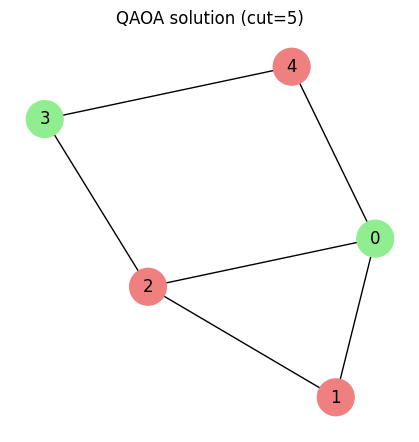

In [2]:

def bitstring_to_assignment(bs):
    return [int(c) for c in bs[::-1]]

def maxcut_value(x, graph):
    val = 0
    for i, j in graph.edges():
        if x[i] != x[j]:
            val += 1
    return val

def build_qaoa_circuit(gammas, betas, graph, edge_order=None):
    
    n = graph.number_of_nodes()
    p = len(gammas)
    qc = QuantumCircuit(n, name=f"QAOA_p{p}")

    qc.h(range(n))
    
    edges = list(graph.edges()) if edge_order is None else edge_order

    for layer in range(p):
        gamma = float(gammas[layer])
        
        for (i, j) in edges:
            qc.cx(i, j)
            qc.rz(2 * gamma, j)
            qc.cx(i, j)
        beta = float(betas[layer])
        for q in range(n):
            qc.rx(2 * beta, q)

    return qc

def expectation_cut_for_params(params, p, graph):
    gammas = params[:p]
    betas = params[p:]
    qc = build_qaoa_circuit(gammas, betas, graph)
    sv = Statevector.from_label("0" * graph.number_of_nodes())
    sv = sv.evolve(qc)
    probs = sv.probabilities_dict()
    expected = 0.0
    for bs, prob in probs.items():
        x = bitstring_to_assignment(bs)
        expected += prob * maxcut_value(x, graph)
    return expected

def qaoa_objective(params, p, graph):
    return -expectation_cut_for_params(params, p, graph) 


if __name__ == "__main__":

    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(0,4),(0,2)])
    n = G.number_of_nodes()

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(4,4))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=700, edge_color="gray")
    plt.title("MaxCut graph")
    plt.show()

    p = 1
    rng = np.random.default_rng(1234)
    init_gamma = rng.random(p) * 0.5
    init_beta  = rng.random(p) * 0.5
    init_params = np.concatenate([init_gamma, init_beta])

    print("Initial params:", init_params)

    res = minimize(qaoa_objective, x0=init_params, args=(p, G),
                   method="COBYLA", options={"maxiter": 300, "tol":1e-3})
    print("Optimizer msg:", res.message)

    opt_params = res.x
    opt_gammas = opt_params[:p]
    opt_betas  = opt_params[p:]
    print("Optimal gammas:", opt_gammas, "betas:", opt_betas)
    
    edge_order = [(0,1),(0,2),(1,2),(2,3),(3,4),(0,4)] 
    qc_opt = build_qaoa_circuit(opt_gammas, opt_betas, G, edge_order=edge_order)

    qc_for_draw = qc_opt.copy()
    qc_for_draw.reverse_bits() 

    fig = qc_for_draw.draw(output="mpl", idle_wires=False, fold=200)
    fig.suptitle("QAOA circuit (visual layout approximating paper figure)", fontsize=10)
    plt.show()

    sv = Statevector.from_label("0" * n).evolve(qc_opt)
    probs = sv.probabilities_dict()
    sorted_probs = sorted(probs.items(), key=lambda kv: -kv[1])

    print("\nTop measured bitstrings & probabilities (Statevector):")
    for bs, pprob in sorted_probs[:8]:
        x = bitstring_to_assignment(bs)
        cut_val = maxcut_value(x, G)
        print(f"{bs}  prob={pprob:.4f}  assignment={x}  cut={cut_val}")

    best_bs, best_prob = sorted_probs[0]
    best_assignment = bitstring_to_assignment(best_bs)
    best_cut_val = maxcut_value(best_assignment, G)
    print(f"\nChosen solution (most probable): {best_bs} -> assignment {best_assignment}, cut value {best_cut_val}")

    color_map = ["lightcoral" if best_assignment[i] == 0 else "lightgreen" for i in range(n)]
    plt.figure(figsize=(4,4))
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=700, edge_color="black")
    plt.title(f"QAOA solution (cut={best_cut_val})")
    plt.show()


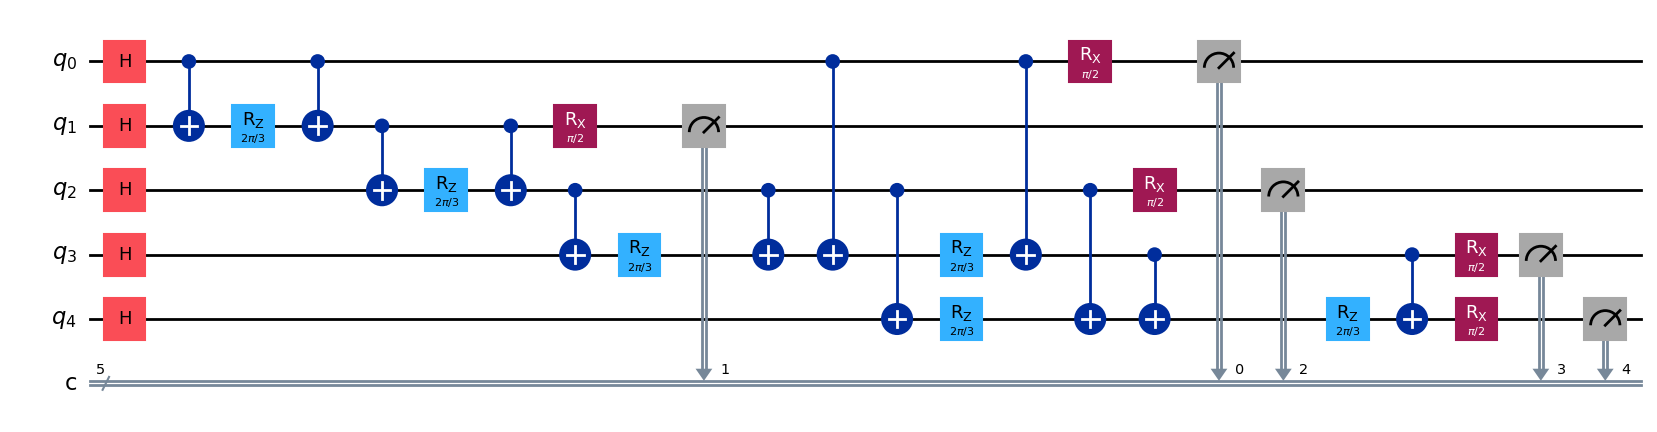

In [6]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5, 5)

for q in range(5):
    qc.h(q)
    
# Edge (0,1)
qc.cx(0,1) 
qc.rz(2*np.pi/3,1)
qc.cx(0,1)
# Edge (1,2)
qc.cx(1,2)
qc.rz(2*np.pi/3,2)
qc.cx(1,2)
# Edge (2,3)
qc.cx(2,3)
qc.rz(2*np.pi/3,3)
qc.cx(2,3)
# Edge (0,3)
qc.cx(0,3)
qc.rz(2*np.pi/3,3)
qc.cx(0,3)

qc.rx(np.pi/2,0)
qc.rx(np.pi/2,1)

qc.measure(0,0)
qc.measure(1,1)

qc.cx(2,4)
qc.rz(2*np.pi/3,4)
qc.cx(2,4)
qc.rx(np.pi/2,2)

qc.measure(2,2)

qc.cx(3,4)
qc.rz(2*np.pi/3,4)
qc.cx(3,4)
qc.rx(np.pi/2,3)
qc.rx(np.pi/2,4)

qc.measure(3,3)
qc.measure(4,4)


qc.draw(output="mpl", fold=160)


In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token="iuPnYAz84WdLrvmyl3gt4feNZ927Lp3JEzA3WjBHtXOw",
    instance="youssef" 
)
print("✅ Connected to IBM Quantum")
print("Available backends:")
print(service.backends())

✅ Connected to IBM Quantum
Available backends:
[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]
